In [308]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [309]:
print(tf.__version__)

2.10.0


In [310]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

### Seprating Training and Testing Data

In [311]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [312]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .20)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [313]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']

In [314]:
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [315]:
test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    217
1     63
Name: binding, dtype: int64


### Over Sampling On the Main Data

In [316]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(table.sequence).reshape(-1,1),table.binding)

In [317]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    722
1    722
Name: binding, dtype: int64
0    217
1     63
Name: binding, dtype: int64


Extracting Features in Binary vectorized format

In [318]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [319]:
print(training_split.shape)
print(test_split.shape)

(1444, 84482)
(280, 84482)


In [320]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
# print(train_result.shape)
# print(test_result.shape)


In [321]:
training_split

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Modeling Neural Network

#### Early Stopping Criteria

In [332]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')
        current_test_precision = logs.get('val_precision')
        current_test_recall= logs.get('val_recall')
        if current_train_precision==0 or current_train_recall==0 or current_test_precision==0 or current_test_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        self.f1_test = (2*current_test_precision*current_test_recall) / (current_test_precision+current_test_recall)
        if abs(self.f1_train-self.f1_test) < .02 and 1>self.f1_test>.979:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('F1 TESTING: ' , self.f1_test)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")


#### Neural Network Size (hypermater selection explained in the report)

In [333]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    tf.keras.layers.Dense(26,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
    tf.keras.layers.Dense(26,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#### Metrics to moniter in every pass

In [334]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

In [335]:
num_epochs = 350 ## Training will stop much before 350 iteration if the Criteria is Met
history = model.fit(training_split, train_result,
                    epochs=num_epochs,
                    batch_size=70,
                    validation_data=(test_split, test_result),
                    callbacks=[EarlyStoppingMonitor()])
# ,callbacks=[tf.keras.callbacks.EarlyStopping()]

Epoch 1/350


2022-10-09 17:32:09.062372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 40.9235 - tp: 599.0000 - fp: 195.0000 - tn: 527.0000 - fn: 123.0000 - precision: 0.7544 - recall: 0.8296

2022-10-09 17:32:10.569474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 69ms/step - loss: 40.9235 - tp: 599.0000 - fp: 195.0000 - tn: 527.0000 - fn: 123.0000 - precision: 0.7544 - recall: 0.8296 - val_loss: 15.6265 - val_tp: 60.0000 - val_fp: 15.0000 - val_tn: 202.0000 - val_fn: 3.0000 - val_precision: 0.8000 - val_recall: 0.9524
Epoch 2/350
21/21 [==============================] - 1s 44ms/step - loss: 10.0645 - tp: 606.0000 - fp: 31.0000 - tn: 691.0000 - fn: 116.0000 - precision: 0.9513 - recall: 0.8393 - val_loss: 7.0656 - val_tp: 54.0000 - val_fp: 9.0000 - val_tn: 208.0000 - val_fn: 9.0000 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 3/350
21/21 [==============================] - 1s 44ms/step - loss: 6.2679 - tp: 542.0000 - fp: 19.0000 - tn: 703.0000 - fn: 180.0000 - precision: 0.9661 - recall: 0.7507 - val_loss: 5.7482 - val_tp: 41.0000 - val_fp: 6.0000 - val_tn: 211.0000 - val_fn: 22.0000 - val_precision: 0.8723 - val_recall: 0.6508
Epoch 4/350
21/21 [==============================] - 1s 44ms/step - lo

## Loss and F1-score Visualization

Text(0.5, 1.0, 'F1-Score')

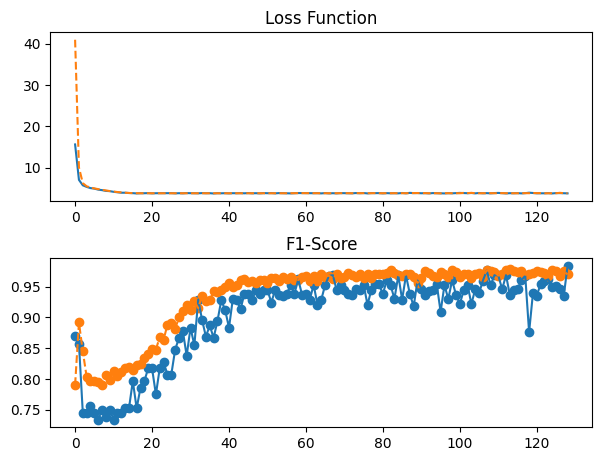

In [336]:
fig, (ax1,ax2) = plt.subplots(2,1)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)
fig.tight_layout(pad=2.0)
ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
ax1.set_title('Loss Function')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
f1_train =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
f1_test = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')
ax2.scatter(history.epoch, f1_test)
ax2.scatter(history.epoch, f1_train)
ax2.plot(history.epoch, f1_test,'-')
ax2.plot(history.epoch, f1_train,'--')
ax2.set_title('F1-Score')
# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')

### Transformation and Prediction on unlabeled data

In [337]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [338]:
unlabeled_test_sequence = vectorizer_best.transform(table_test.sequence).toarray()

In [339]:
print(unlabeled_test_sequence.shape)

(350, 84482)


In [340]:
predicted = model.predict(unlabeled_test_sequence)

 6/11 [===============>..............] - ETA: 0s

2022-10-09 17:34:55.128748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 28ms/step


In [341]:
final_result = [1 if i>=.5 else 0 for i in predicted ]

In [342]:
print(len(final_result))

350


In [343]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], final_result))
outfile.close()